## Deps

In [2]:
using Optics_in_the_length_gauge
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful
using Statistics
using Optics_in_the_length_gauge
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful
using Statistics
using StaticArrays
using Parameters
using CairoMakie
using LaTeXStrings
using LMC
using JLD2
using FileIO
# add https://github.com/fernandopenaranda/Optics_in_the_length_gauge
# units meV, fs, K
const kB = (PhysicalConstants.CODATA2018.k_B |> u"eV/K").val
const μB = (PhysicalConstants.CODATA2018.BohrMagneton |> u"eV/T").val
const ħ = PhysicalConstants.CODATA2018.ħ
const e = PhysicalConstants.CODATA2018.e
const C = ((e^3 / ħ^2) |> u"μA/V^2/s").val
const C_cd = ((e^2/ħ) |> u"μA/V").val
const ħ_ev_s = (ħ |> u"eV*s").val
const ang_to_m = 1e-10
const Kb_in_mev = 1e3* kB


proj_folder = dirname(pwd())
rhomb_folder = proj_folder * "/model/rhombohedral/"
common_folder = proj_folder * "/comfunctions/"
figures_folder = proj_folder * "/Paper/Figures/"

"/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/Figures/"

## Plotting functions

In [5]:
function plotmapp!(ax, kx, ky, Zs; colmap = missing, colrange = missing)
    if isa(colmap, Missing)
        cmap = cgrad([:black,:red,:white]) 
    else
        cmap = cgrad(colmap) 
    end
    if isa(colrange, Missing)
        hm = heatmap!(ax, kx, ky, real(Zs), rasterize = true, dpi = 1000)#, colormap = cgrad([:red,:black]))
    else
        hm = heatmap!(ax, kx, ky, real(Zs), colormap = cmap, colorrange= colrange, rasterize = true,dpi = 1000)
    end
    return hm
    # cb = Colorbar(fig[1, 2], hm)
end
xx_drude_presets(N, μ,ξ, evals) = 
    xx_drude_presets(N, μ, ξ, p; evals = evals, T = T, τ = τ)
lmcnoshift_presets(N, μ, ξ, evals) = xxx_lmc_presets(N, μ, ξ, p; evals = evals,
    T = T, τ = τ, berry_contribution = true, omm_contribution = true, 
    fermi_surface = false, with_shift = false)

function figure_berry(N, μlist, ξ, p, T; B = 10, kpoints = 100, colrange = [-1,1], fontsize = 10)
    colorlist = [:lightblue, :lavender, :peachpuff]
    colorlist = [:cornflowerblue, :mediumpurple, :lightsalmon]
    fig = Figure(size = (600,800))
    prefactor = maximum(colrange)
    m2toang2 = 1e20
    colrange2 = colrange
    colmap = cgrad([:white, :black])

    
    axbands = Axis(fig[1,1:3], ylabel = L"$\text{E}\ \text{[meV]}$")
    LMC.abcNplotbandsk(axbands, N, kpoints, Params_rhombohedral(p, ξ =1); ylims = [-1, 1], color = :black)
    LMC.abcNplotbandsk(axbands, N, kpoints, Params_rhombohedral(p, ξ =-1); ylims = [-1, 1], color = :gray)
    
    ylims!(axbands, -0,8)
    axbands.yticks = [0, 4, 8]
    
    [hlines!(axbands, μlist[i], color = colorlist[i]) for i in 1:length(μlist)]
    
    #_________________________________________
    ga = fig[2:4, 1:3] = GridLayout()
    colrange_omegaz = [0,0.5]

    prefactor = 1e5
        
    lmcpresets1 = xxx_lmc_presets(N, μlist[1], ξ, p; T = T)
    lmcpresets2 = xxx_lmc_presets(N, μlist[2], ξ, p; T = T)
    lmcpresets3 = xxx_lmc_presets(N, μlist[3], ξ, p; T = T)


        kxs, kys, Z2s = kresolved_Ωz(p, lmcpresets1, points = kpoints) # Ωxy_fn
        Z2s .*= m2toang2 ./ prefactor
        kxs, kys, Z3s = kresolved_Ωz(p, lmcpresets2, points = kpoints) # Ωxy_fn
        Z3s .*= m2toang2 ./ prefactor
        kxs, kys, Z4s = kresolved_Ωz(p, lmcpresets3, points = kpoints) # Ωxy_fn
        Z4s .*= m2toang2 ./ prefactor
        
    
    ax2 = Axis(ga[1,1], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)#, title = "|⟨Ωz⟩|")
    ax3 = Axis(ga[1,2], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    ax4 = Axis(ga[1,3], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    
    hmm = plotmap!(ax2, kxs, kys, abs.(Z2s), colrange = colrange_omegaz, colmap = colmap)
    hmm = plotmap!(ax3, kxs, kys, abs.(Z3s), colrange = colrange_omegaz, colmap = colmap)
    hmm = plotmap!(ax4, kxs, kys, abs.(Z4s), colrange = colrange_omegaz, colmap = colmap)

    ax2.xticks = [-0.1, 0, 0.1]
    ax2.yticks = [-0.1, 0, 0.1]

    
    #_________________________________________
    colrange_omegap = [0,1]

    pboth_contr(μ) = xxx_lmc_presets(N, μ, ξ, p; T = T, berry_contribution = true, omm_contribution = true)
    pΩ_contr(μ) = xxx_lmc_presets(N, μ, ξ, p; T = T, berry_contribution = true, omm_contribution = false)
    pomm_contr(μ) = xxx_lmc_presets(N, μ, ξ, p; T = T, berry_contribution = false, omm_contribution = true)
    
        kxs, kys, Z5s = kresolved_Ωin(p, pΩ_contr(μlist[1]), points = kpoints) 
        kxs, kys, Z6s = kresolved_Ωin(p, pΩ_contr(μlist[2]), points = kpoints) 
        kxs, kys, Z7s = kresolved_Ωin(p, pΩ_contr(μlist[3]), points = kpoints) 
        Z5s .*= m2toang2 ./ prefactor
        Z6s .*= m2toang2 ./ prefactor
        Z7s .*= m2toang2 ./ prefactor
    
    ax5 = Axis(ga[2,1], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)#, title = "|⟨Ω||⟩_FS|")
    ax6 = Axis(ga[2,2],  xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    ax7 = Axis(ga[2,3],  xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    
    ax5.xticks = [-0.1, 0, 0.1]
    ax5.yticks = [-0.1, 0, 0.1]
    ax6.xticks = [-0.1, 0, 0.1]
    ax7.xticks = [-0.1, 0, 0.1]



    hm5 = plotmap!(ax5, kxs, kys, abs.(Z5s), colrange = colrange_omegap, colmap = colmap)
    hm6 = plotmap!(ax6, kxs, kys, abs.(Z6s), colrange = colrange_omegap, colmap = colmap)
    hm7 = plotmap!(ax7, kxs, kys, abs.(Z7s), colrange = colrange_omegap, colmap = colmap)

    Label(fig[1, 1:3, Top()], L"$\mathrm{N} = 7$"; fontsize = fontsize, padding = (4, 6, -16, 0))

    scatter!(ax2, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[1])
    scatter!(ax3, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[2])
    scatter!(ax4, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[3])
    scatter!(ax5, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[1])
    scatter!(ax6, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[2])
    scatter!(ax7, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[3])
    
    
    ax8 = Axis(ga[3,1], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)#, title = "|⟨Ω||⟩_FS|")
    ax9 = Axis(ga[3,2],  xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    ax10 = Axis(ga[3,3],  xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    
    #_________________________________________
    kres(p, ps, points) = kresolvedlmc(p, ps; points = points, Ω_contr = ps.berry_contribution, omm_contr = ps.omm_contribution, fermi_surface = ps.fermi_surface, with_shift = ps.with_shift)
    # components of the lmc
    
    kxs, kys, Z8s = kres(p, pboth_contr(μlist[1]), kpoints)
    kxs, kys, Z9s = kres(p, pboth_contr(μlist[2]), kpoints)
    kxs, kys, Z10s = kres(p, pboth_contr(μlist[3]), kpoints)

    Z8s .*= B * m2toang2 ./ prefactor 
    Z9s .*= B * m2toang2 ./ prefactor #  necesitas ponerlo a las mismas unidades posiblemente no son las mismsas cmapo magentico y algo mas
    Z10s .*= B * m2toang2 ./ prefactor


    colmap = [:lightblue, :black, :pink]
    colrange_omegad = [-1, 1] .* 0.5


    hm8 = plotmapp!(ax8, kxs, kys, abs.(Z2s) .-  abs.(Z8s), colrange = colrange_omegad, colmap = colmap)
    hm9 = plotmapp!(ax9, kxs, kys,abs.(Z3s) .- abs.(Z9s), colrange = colrange_omegad, colmap = colmap)
    hm10 = plotmapp!(ax10, kxs, kys, abs.(Z4s) .- abs.(Z10s), colrange = colrange_omegad, colmap = colmap)

    
    # hm8 = plotmapp!(ax8, kxs, kys, abs.(Z2s)-abs.(Z5s), colrange = colrange_omegad, colmap = colmap)
    # hm9 = plotmapp!(ax9, kxs, kys, abs.(Z3s)-abs.(Z6s), colrange = colrange_omegad, colmap = colmap)
    # hm10 = plotmapp!(ax10, kxs, kys, abs.(Z4s)-abs.(Z7s), colrange = colrange_omegad, colmap = colmap)


  
    
    scatter!(ax8, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[1])
    scatter!(ax9, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[2])
    scatter!(ax10, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[3])


    
    ax8.xticks = [-0.1, 0, 0.1]
    ax8.yticks = [-0.1, 0, 0.1]
    ax9.xticks = [-0.1, 0, 0.1]
    ax10.xticks = [-0.1, 0, 0.1]
    
    hidexdecorations!(ax2)
    hidexdecorations!(ax3)
    hidexdecorations!(ax4)
    hideydecorations!(ax3)
    hideydecorations!(ax4)
    hideydecorations!(ax6)
    hideydecorations!(ax7)
    hidexdecorations!(ax7)
    hidexdecorations!(ax6)
    hidexdecorations!(ax5)
    hideydecorations!(ax9)
    hideydecorations!(ax10)
    
    text!(axbands, "a)", position = (-0.14, 7.3), fontsize = fontsize -2)
    text!(ax2, "b)", position = (-0.13, 0.11), fontsize = fontsize -2)
    text!(ax3, "c)", position = (-0.13, 0.11), fontsize = fontsize -2)
    text!(ax4, "d)", position = (-0.13, 0.11), fontsize = fontsize -2)
    text!(ax5, "e)", position =(-0.13, 0.11), fontsize = fontsize -2)
    text!(ax6, "f)", position =(-0.13, 0.11), fontsize = fontsize -2)
    text!(ax7, "g)", position =(-0.13, 0.11), fontsize = fontsize -2)
    text!(ax8, "h)", position =(-0.13, 0.11), fontsize = fontsize -2, color = :white)
    text!(ax9, "i)", position = (-0.13, 0.11), fontsize = fontsize -2, color = :white)
    text!(ax10, "j)", position =(-0.13, 0.11), fontsize = fontsize -2, color = :white)

    Colorbar(fig[2,4], hmm, labelpadding = -30, label = L"$|\langle \Omega_z\rangle| \text{ } [Å^2]$", ticks =  ([0, 0.5], ["0",L"$5 \times 10^4$"]))# "⟨Ωz⟩ [[×10^$(Int(log10(prefactor))) ]Å^2] ", ticks = [0, 0.5, 1])
    Colorbar(fig[3,4], hm5, labelpadding = -5, label = L"$|\langle \Omega_x\rangle_{\text{FS}}| \text{ }[Å^2]$", ticks = ([0, 1], ["0",L"$10^5$"]))
    # Colorbar(fig[4,4], hm10, label = L"$|\langle \Omega_z\rangle| - |\langle \Omega_x\rangle_{\text{FS}}| [Å^2]$", ticks = ([-1, 0, 1], [L"$-10^5$","0",L"$10^5$"]))
    Colorbar(fig[4,4], hm10,labelpadding = -50, label = L"$|\langle \Omega_z\rangle| \minus |\text{I}|B_{x} \text{ }[Å^2\frac{e^2}{h}]$", ticks = ([-0.5, 0, 0.5], [L"$-5 \times 10^4$","0",L"$5 \times 10^5$"]))

    fig
end

figure_berry (generic function with 1 method)

In [6]:
function lat_figure_berry_(N, μlist, ξ, p, T; kpoints = 10, fontsizetheme = 15, xls = 100, yls = 24, xticksi = 20, yticksi = 10)
    with_theme(merge(theme_latexfonts(), Theme(fontsize = fontsizetheme, xlabelsize =  xls,   
    ylabelsize = yls, xticklabelsize = xticksi,  yticklabelsize = yticksi))) do #
        figure_berry(N, μlist, ξ, p, T; kpoints = kpoints, fontsize = fontsizetheme)     
    end
end

lat_figure_berry_ (generic function with 1 method)

In [16]:

function figure_berry_opt2(N, μlist, ξ, p, T; B = 10, kpoints = 100, colrange = [-1,1], fontsize = 10)
    colorlist = [:lightblue, :lavender, :peachpuff]
    colorlist = [:cornflowerblue, :mediumpurple, :lightsalmon]
    fig = Figure(size = (600,600))
    prefactor = maximum(colrange)
    m2toang2 = 1e20
    colrange2 = colrange
    colmap = cgrad([:white, :black])
    
    #_________________________________________
    ga = fig[1:3, 1:3] = GridLayout()
    colrange_omegaz = [0,0.5]

    prefactor = 1e5
        
    lmcpresets1 = xxx_lmc_presets(N, μlist[1], ξ, p; T = T)
    lmcpresets2 = xxx_lmc_presets(N, μlist[2], ξ, p; T = T)
    lmcpresets3 = xxx_lmc_presets(N, μlist[3], ξ, p; T = T)


        kxs, kys, Z2s = kresolved_Ωz(p, lmcpresets1, points = kpoints) # Ωxy_fn
        Z2s .*= m2toang2 ./ prefactor
        kxs, kys, Z3s = kresolved_Ωz(p, lmcpresets2, points = kpoints) # Ωxy_fn
        Z3s .*= m2toang2 ./ prefactor
        kxs, kys, Z4s = kresolved_Ωz(p, lmcpresets3, points = kpoints) # Ωxy_fn
        Z4s .*= m2toang2 ./ prefactor
        
    
    ax2 = Axis(ga[1,1], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)#, title = "|⟨Ωz⟩|")
    ax3 = Axis(ga[1,2], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    ax4 = Axis(ga[1,3], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    
    hmm = plotmap!(ax2, kxs, kys, abs.(Z2s), colrange = colrange_omegaz, colmap = colmap)
    hmm = plotmap!(ax3, kxs, kys, abs.(Z3s), colrange = colrange_omegaz, colmap = colmap)
    hmm = plotmap!(ax4, kxs, kys, abs.(Z4s), colrange = colrange_omegaz, colmap = colmap)

    ax2.xticks = [-0.1, 0, 0.1]
    ax2.yticks = [-0.1, 0, 0.1]

    
    #_________________________________________
    colrange_omegap = [0,1]

    pboth_contr(μ) = xxx_lmc_presets(N, μ, ξ, p; T = T, berry_contribution = true, omm_contribution = true)
    pΩ_contr(μ) = xxx_lmc_presets(N, μ, ξ, p; T = T, berry_contribution = true, omm_contribution = false)
    pomm_contr(μ) = xxx_lmc_presets(N, μ, ξ, p; T = T, berry_contribution = false, omm_contribution = true)
    
        kxs, kys, Z5s = kresolved_Ωin(p, pΩ_contr(μlist[1]), points = kpoints) 
        kxs, kys, Z6s = kresolved_Ωin(p, pΩ_contr(μlist[2]), points = kpoints) 
        kxs, kys, Z7s = kresolved_Ωin(p, pΩ_contr(μlist[3]), points = kpoints) 
        Z5s .*= m2toang2 ./ prefactor
        Z6s .*= m2toang2 ./ prefactor
        Z7s .*= m2toang2 ./ prefactor
    
    ax5 = Axis(ga[2,1], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)#, title = "|⟨Ω||⟩_FS|")
    ax6 = Axis(ga[2,2],  xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    ax7 = Axis(ga[2,3],  xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    
    ax5.xticks = [-0.1, 0, 0.1]
    ax5.yticks = [-0.1, 0, 0.1]
    ax6.xticks = [-0.1, 0, 0.1]
    ax7.xticks = [-0.1, 0, 0.1]



    hm5 = plotmap!(ax5, kxs, kys, abs.(Z5s), colrange = colrange_omegap, colmap = colmap)
    hm6 = plotmap!(ax6, kxs, kys, abs.(Z6s), colrange = colrange_omegap, colmap = colmap)
    hm7 = plotmap!(ax7, kxs, kys, abs.(Z7s), colrange = colrange_omegap, colmap = colmap)



    scatter!(ax2, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[1])
    scatter!(ax3, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[2])
    scatter!(ax4, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[3])
    scatter!(ax5, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[1])
    scatter!(ax6, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[2])
    scatter!(ax7, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[3])
    
    
    ax8 = Axis(ga[3,1], xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)#, title = "|⟨Ω||⟩_FS|")
    ax9 = Axis(ga[3,2],  xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    ax10 = Axis(ga[3,3],  xlabel = L"$k_x a_0$", ylabel = L"$k_y a_0$", ylabelsize = fontsize +2, xlabelsize = fontsize +2)
    
    #_________________________________________
    kres(p, ps, points) = kresolvedlmc(p, ps; points = points, Ω_contr = ps.berry_contribution, omm_contr = ps.omm_contribution, fermi_surface = ps.fermi_surface, with_shift = ps.with_shift)
    # components of the lmc
    
    kxs, kys, Z8s = kres(p, pboth_contr(μlist[1]), kpoints)
    kxs, kys, Z9s = kres(p, pboth_contr(μlist[2]), kpoints)
    kxs, kys, Z10s = kres(p, pboth_contr(μlist[3]), kpoints)

    Z8s .*= B * m2toang2 ./ prefactor 
    Z9s .*= B * m2toang2 ./ prefactor #  necesitas ponerlo a las mismas unidades posiblemente no son las mismsas cmapo magentico y algo mas
    Z10s .*= B * m2toang2 ./ prefactor


    colmap = [:lightblue, :black, :pink]
    colrange_omegad = [-1, 1] .* 0.5


    hm8 = plotmapp!(ax8, kxs, kys, abs.(Z2s) .-  abs.(Z8s), colrange = colrange_omegad, colmap = colmap)
    hm9 = plotmapp!(ax9, kxs, kys,abs.(Z3s) .- abs.(Z9s), colrange = colrange_omegad, colmap = colmap)
    hm10 = plotmapp!(ax10, kxs, kys, abs.(Z4s) .- abs.(Z10s), colrange = colrange_omegad, colmap = colmap)


    scatter!(ax8, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[1])
    scatter!(ax9, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[2])
    scatter!(ax10, [0.12], [0.12], markersize=15, marker=:rect, color=colorlist[3])

    ax8.xticks = [-0.1, 0, 0.1]
    ax8.yticks = [-0.1, 0, 0.1]
    ax9.xticks = [-0.1, 0, 0.1]
    ax10.xticks = [-0.1, 0, 0.1]
    
    hidexdecorations!(ax2)
    hidexdecorations!(ax3)
    hidexdecorations!(ax4)
    hideydecorations!(ax3)
    hideydecorations!(ax4)
    hideydecorations!(ax6)
    hideydecorations!(ax7)
    hidexdecorations!(ax7)
    hidexdecorations!(ax6)
    hidexdecorations!(ax5)
    hideydecorations!(ax9)
    hideydecorations!(ax10)
    
    text!(ax2, "a)", position = (-0.13, 0.11), fontsize = fontsize -2)
    text!(ax3, "b)", position = (-0.13, 0.11), fontsize = fontsize -2)
    text!(ax4, "c)", position = (-0.13, 0.11), fontsize = fontsize -2)
    text!(ax5, "d)", position =(-0.13, 0.11), fontsize = fontsize -2)
    text!(ax6, "e)", position =(-0.13, 0.11), fontsize = fontsize -2)
    text!(ax7, "f)", position =(-0.13, 0.11), fontsize = fontsize -2)
    text!(ax8, "g)", position =(-0.13, 0.11), fontsize = fontsize -2, color = :white)
    text!(ax9, "h)", position = (-0.13, 0.11), fontsize = fontsize -2, color = :white)
    text!(ax10, "i)", position =(-0.13, 0.11), fontsize = fontsize -2, color = :white)

    Colorbar(fig[1,4], hmm, labelpadding = -30, label = L"$|\langle \Omega_z\rangle| \text{ } [Å^2]$", ticks =  ([0, 0.5], ["0",L"$5 \times 10^4$"]))# "⟨Ωz⟩ [[×10^$(Int(log10(prefactor))) ]Å^2] ", ticks = [0, 0.5, 1])
    Colorbar(fig[2,4], hm5, labelpadding = -5, label = L"$|\langle \Omega_x\rangle_{\text{FS}}| \text{ }[Å^2]$", ticks = ([0, 1], ["0",L"$10^5$"]))
    # Colorbar(fig[4,4], hm10, label = L"$|\langle \Omega_z\rangle| - |\langle \Omega_x\rangle_{\text{FS}}| [Å^2]$", ticks = ([-1, 0, 1], [L"$-10^5$","0",L"$10^5$"]))
    Colorbar(fig[3,4], hm10,labelpadding = -50, label = L"$|\langle \Omega_z\rangle| \minus |\text{I}|B_{x} \text{ }[Å^2\frac{e^2}{h}]$", ticks = ([-0.5, 0, 0.5], [L"$-5 \times 10^4$","0",L"$5 \times 10^5$"]))

    fig
end

function lat_figure_berry_opt2(N, μlist, ξ, p, T; kpoints = 10, fontsizetheme = 15, xls = 100, yls = 24, xticksi = 20, yticksi = 10)
    with_theme(merge(theme_latexfonts(), Theme(fontsize = fontsizetheme, xlabelsize =  xls,   
    ylabelsize = yls, xticklabelsize = xticksi,  yticklabelsize = yticksi))) do #
        figure_berry_opt2(N, μlist, ξ, p, T; kpoints = kpoints, fontsize = fontsizetheme)     
    end
end

lat_figure_berry_opt2 (generic function with 1 method)

## Plot

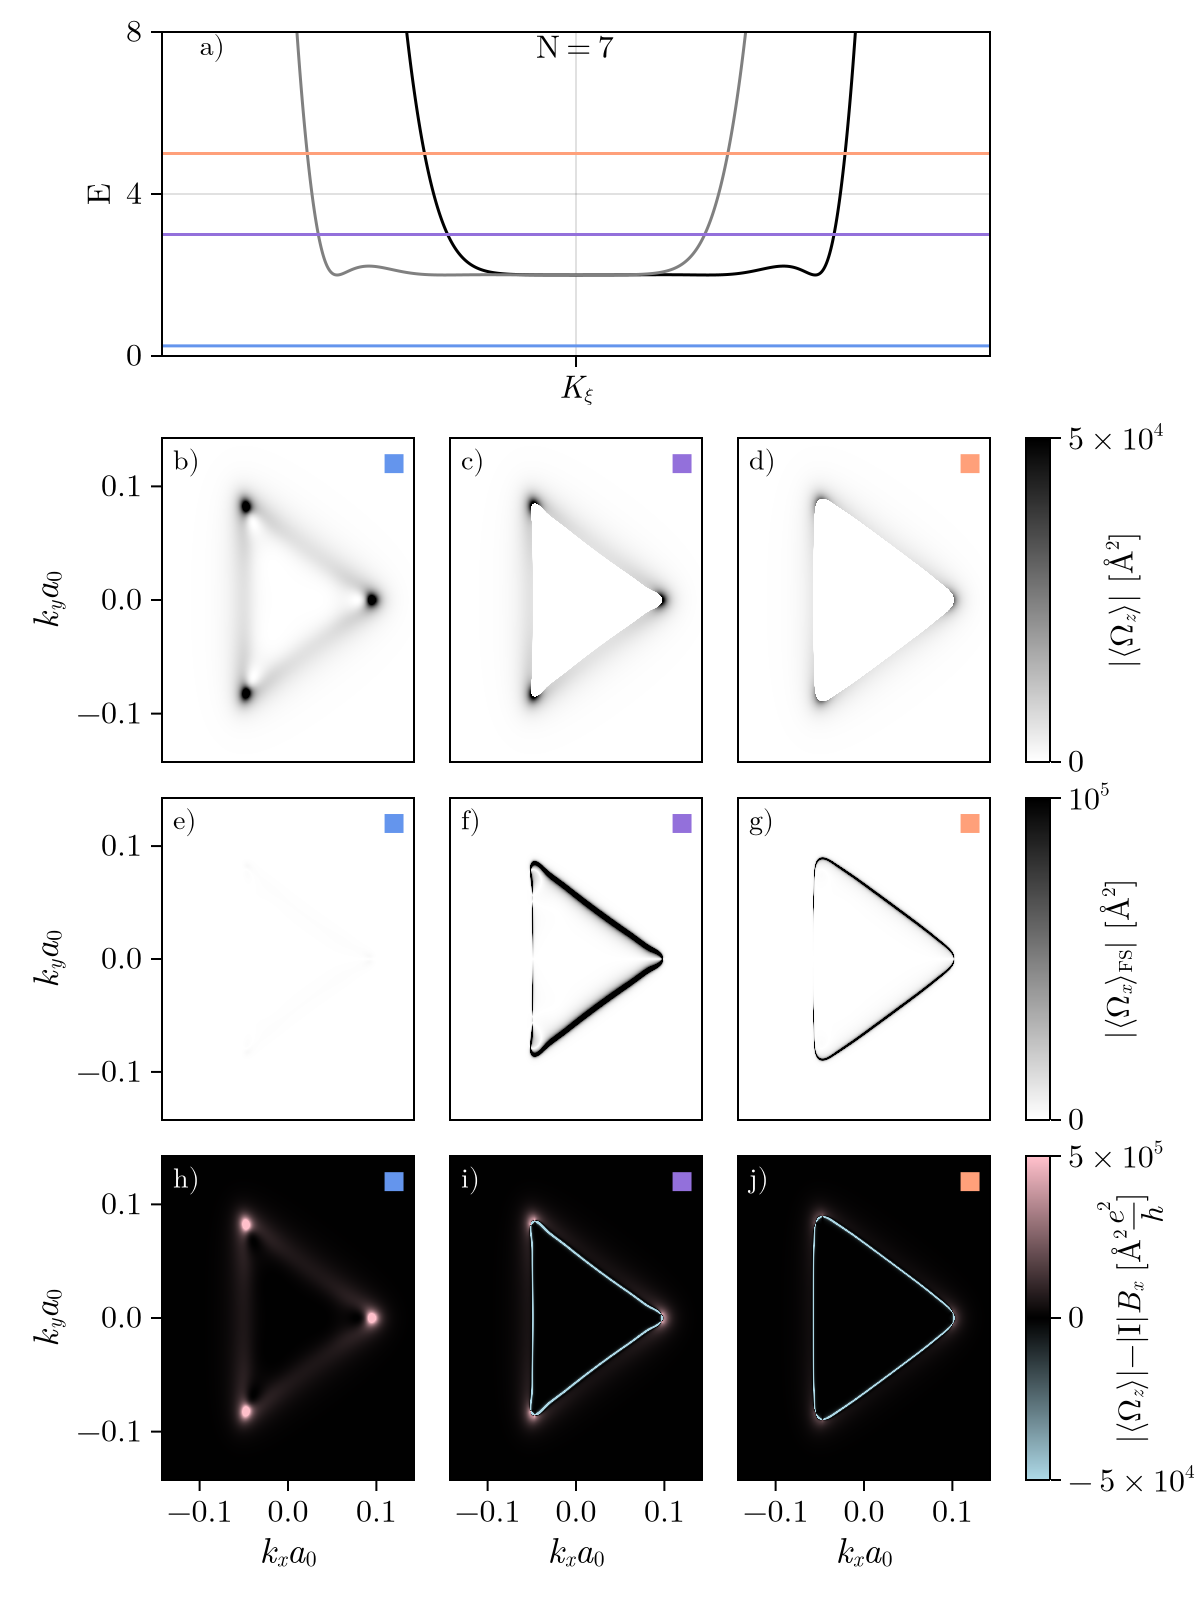

In [92]:
N = 7
p = Params_rhombohedral(1, 0, 3160, 390,-20, 315, 0*44, 2, 0)
τ = 200 # not appearing
μlist = [0.25,3,5]
ξ = 1
T = 0.1
fig3 = lat_figure_berry(N, μlist, ξ, p, T, kpoints = 2500, fontsizetheme = 16)

In [93]:
# v = "v9"
# save("/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/Figures/Figure3$(v).pdf", fig3)
# @save "/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/Figure_2/Figure3v$(v).jld" N μlist ξ p T 

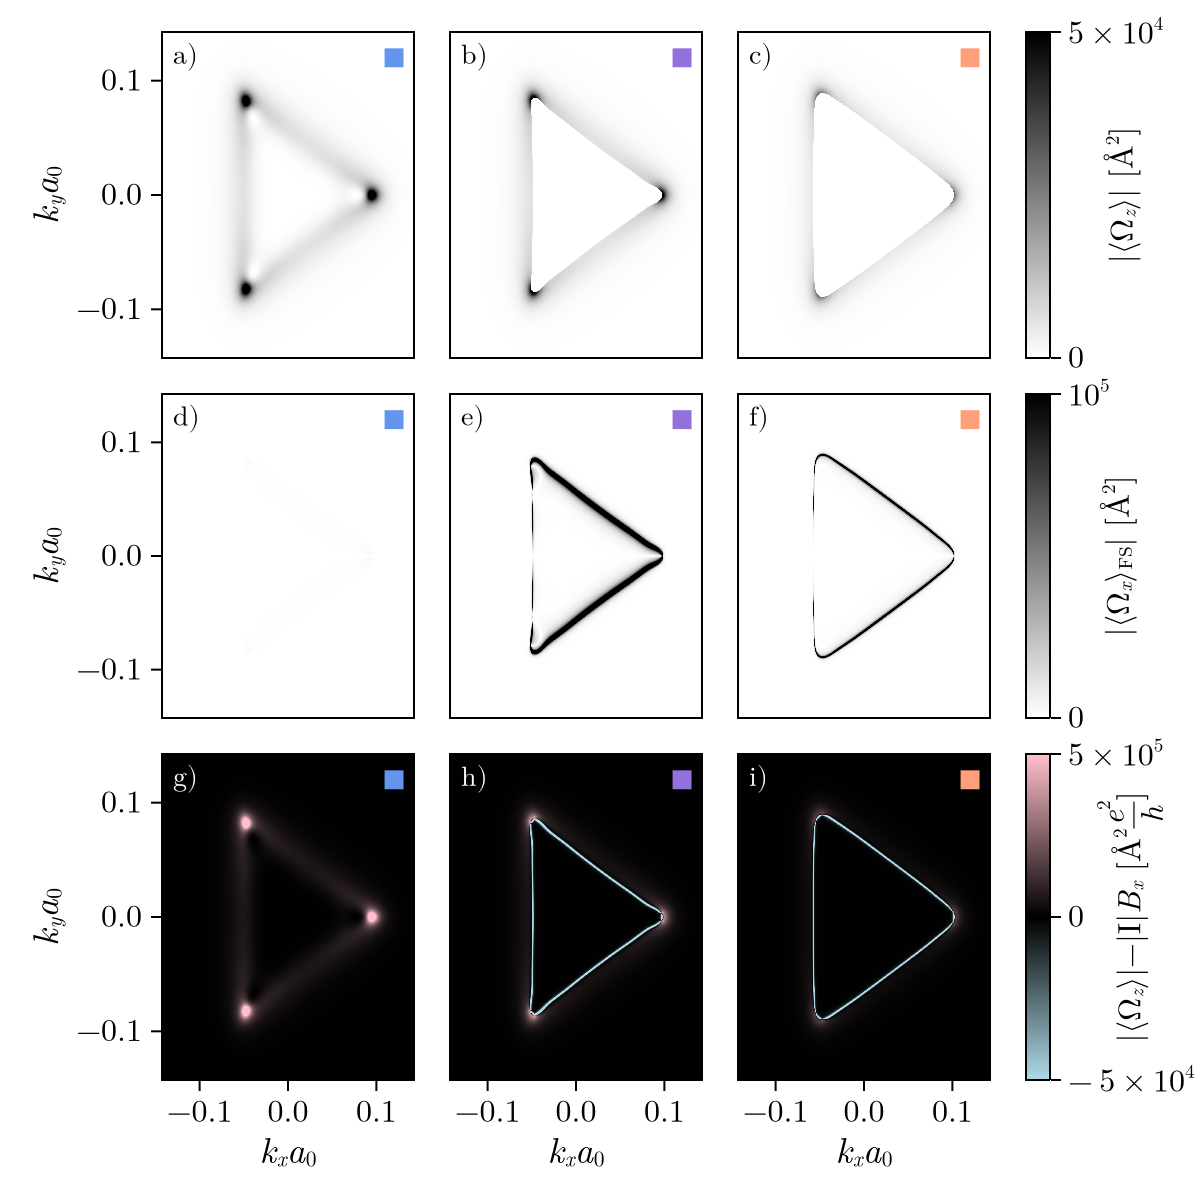

In [17]:
N = 7
p = Params_rhombohedral(1, 0, 3160, 390,-20, 315, 0*44, 2, 0)
τ = 200 # not appearing
μlist = [0.25,3,5]
ξ = 1
T = 0.1
fig3 = lat_figure_berry_opt2(N, μlist, ξ, p, T, kpoints = 2500, fontsizetheme = 16)

In [18]:
v = "v10"
save("/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/Figures/Figure3$(v).pdf", fig3)
@save "/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/Figure_2/Figure3v$(v).jld" N μlist ξ p T 